# dataset Link : https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from catboost import CatBoostClassifier
import shap
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input


from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data.csv")

print("Shape:", df.shape)
df.head()

Shape: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:

print(df.isnull().sum())


df = df.dropna()


target_col = "Bankrupt?"
print("Target distribution:\n", df[target_col].value_counts())

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64
Target distribution:
 Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [4]:

if set(["Total Assets","Total Liabilities","Equity","Current Assets","Current Liabilities",
        "Inventory","EBIT","Interest Expense","Net Income","Gross Profit","Revenue","COGS","Operating Cash Flow"]).issubset(df.columns):

    df["Current_Ratio"] = df["Current Assets"] / df["Current Liabilities"]
    df["Quick_Ratio"] = (df["Current Assets"] - df["Inventory"]) / df["Current Liabilities"]
    df["Debt_to_Equity"] = df["Total Liabilities"] / df["Equity"]
    df["Interest_Coverage"] = df["EBIT"] / (df["Interest Expense"] + 1e-6)
    df["ROA"] = df["Net Income"] / df["Total Assets"]
    df["ROE"] = df["Net Income"] / df["Equity"]
    df["Gross_Margin"] = df["Gross Profit"] / df["Revenue"]
    df["Asset_Turnover"] = df["Revenue"] / df["Total Assets"]
    df["Inventory_Turnover"] = df["COGS"] / (df["Inventory"] + 1e-6)
    df["OCF_to_Debt"] = df["Operating Cash Flow"] / (df["Total Liabilities"] + 1e-6)

print("New features added:", [col for col in df.columns if "_" in col])

New features added: []


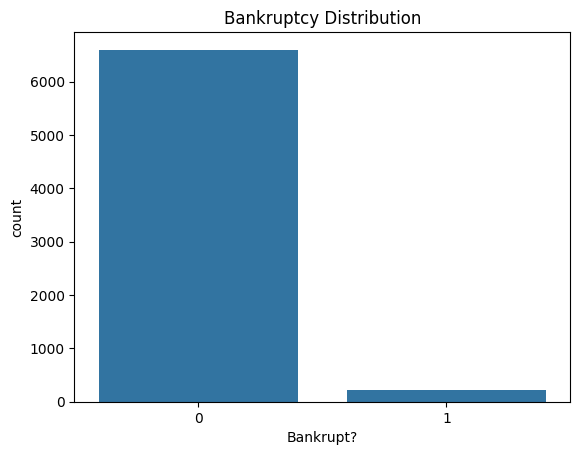

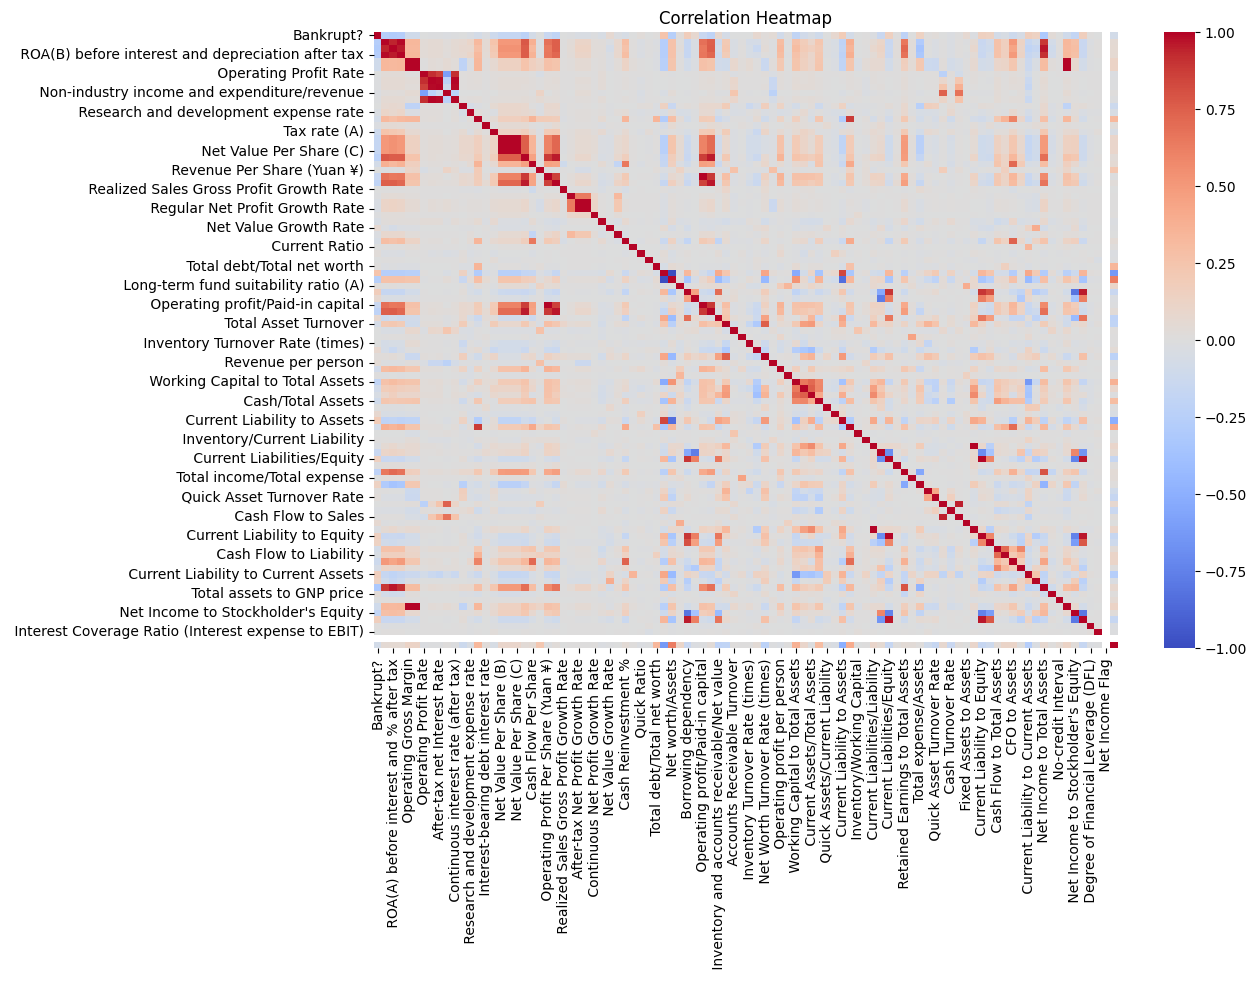

In [5]:

sns.countplot(x=target_col, data=df)
plt.title("Bankruptcy Distribution")
plt.show()


plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [6]:

X = df.drop(columns=[target_col])
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [7]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_res, y_train_res)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, y_pred))

Logistic Regression Results:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      1320
           1       0.20      0.73      0.31        44

    accuracy                           0.90      1364
   macro avg       0.60      0.82      0.63      1364
weighted avg       0.96      0.90      0.92      1364



In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred))

Random Forest Results:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.40      0.61      0.49        44

    accuracy                           0.96      1364
   macro avg       0.69      0.79      0.73      1364
weighted avg       0.97      0.96      0.96      1364



In [9]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')  # no need for use_label_encoder
xgb_model.fit(X_train_res, y_train_res)

y_pred = xgb_model.predict(X_test)
print("XGBoost Results:\n", classification_report(y_test, y_pred))

XGBoost Results:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.49      0.55      0.52        44

    accuracy                           0.97      1364
   macro avg       0.74      0.76      0.75      1364
weighted avg       0.97      0.97      0.97      1364



In [10]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train_res, y_train_res)

y_pred = cat.predict(X_test)
print("CatBoost Results:\n", classification_report(y_test, y_pred))

CatBoost Results:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.45      0.57      0.51        44

    accuracy                           0.96      1364
   macro avg       0.72      0.77      0.74      1364
weighted avg       0.97      0.96      0.97      1364



In [11]:
nn = Sequential([
    Input(shape=(X_train_res.shape[1],)),  # first layer defines input shape
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train_res, y_train_res, epochs=20, batch_size=32, verbose=1)

nn_preds = (nn.predict(X_test) > 0.5).astype(int)
print("Neural Network Results:\n", classification_report(y_test, nn_preds))

Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8933 - loss: 0.2801
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9344 - loss: 0.1866
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9522 - loss: 0.1440
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9598 - loss: 0.1221
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9686 - loss: 0.0995
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9721 - loss: 0.0907
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9759 - loss: 0.0795
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9787 - loss: 0.0695
Epoch 9/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9798 - loss: 0.0634
Epoch 10/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9839 - loss: 0.0548
Epoch 11/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.0459
Epoch 12/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

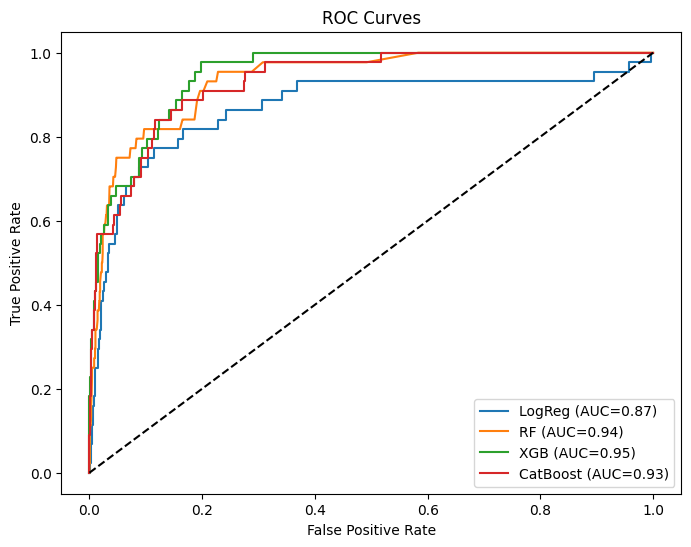

In [12]:
from sklearn.metrics import auc

models = {"LogReg": log_reg, "RF": rf, "XGB": xgb_model, "CatBoost": cat}
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

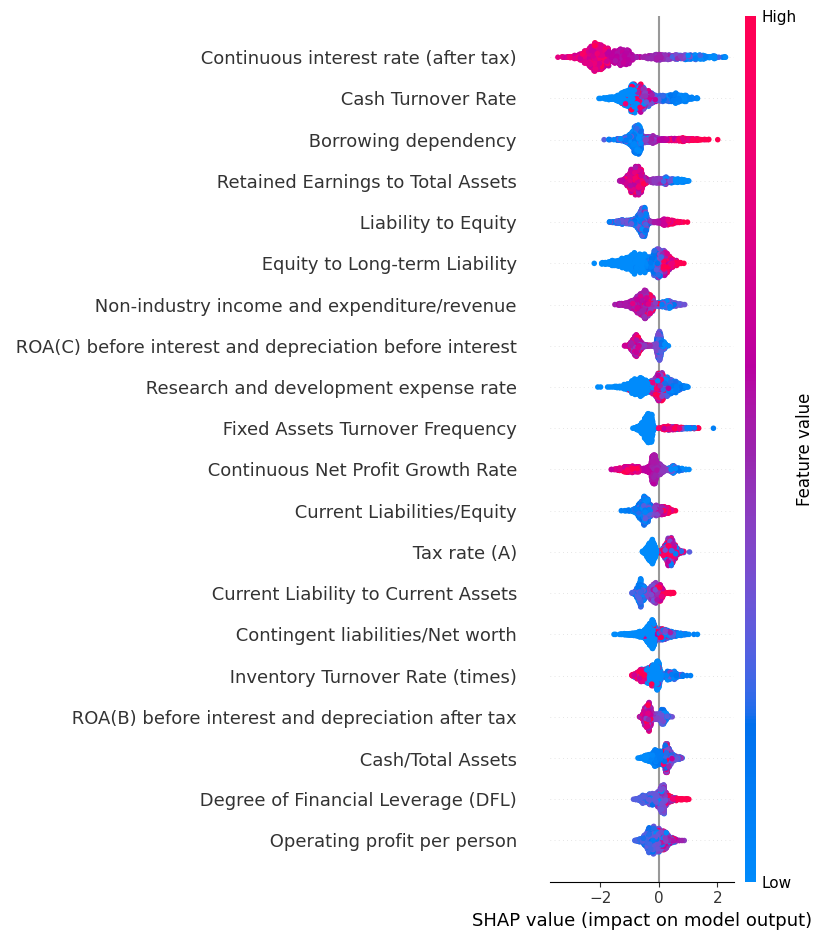

In [13]:
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, feature_names=X.columns)


sample = X_test[0:1]
shap.force_plot(explainer.expected_value, shap_values[0,:], X.columns)


In [14]:
joblib.dump(xgb_model, "bankruptcy_xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']